In [1]:
import os 
import re
import matplotlib.pyplot as plt
import rmgpy.chemkin
import numpy as np
import cantera as ct
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline



In [2]:
def load_chemkin_file(path): 
    """ 
    Load Chemkin file and extract the reactions and species.
    Path should be the path to the species folder.
    """
    
    full_path = os.path.join(path,'chemkin')
    chemkin_path = os.path.join(full_path,'copies', 'copy_chem_annotated.inp')
   # chemkin_path = os.path.join(full_path,'chem_annotated.inp')
    dictionary_path = os.path.join(full_path,'species_dictionary.txt')
    transport_path = os.path.join(full_path,'tran.dat')

    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

    return species_list, reaction_list

## Plot Sensitivity

In [3]:
#we want to focus on the top ___ most sensitive reactions 
n = 20 #len(reaction_list)

In [4]:
def plot_sensitivity(csv_file):
    ############ plotting stuff

    df = pd.read_csv(f'./{csv_file}')

    match = re.search('(\S+)_RMG_sensitivities.csv', file)
    blend = match.group(1)

    fig, ax = plt.subplots()

    plt.xlabel('Sensitivity')
    plt.title(f"Sensitivity for {blend} Model at Refrigerant Volume Fraction with Max Flame Speed%")

    ############# iterate over rows of csv file. 

    for index,row in df.head(n).iterrows(): #Only iterate over the first n rows


        sensitivity, ct_equation, = row['sensitivity'], row['cantera equation']
        ax.barh(ct_equation, sensitivity, color='b', align='center')


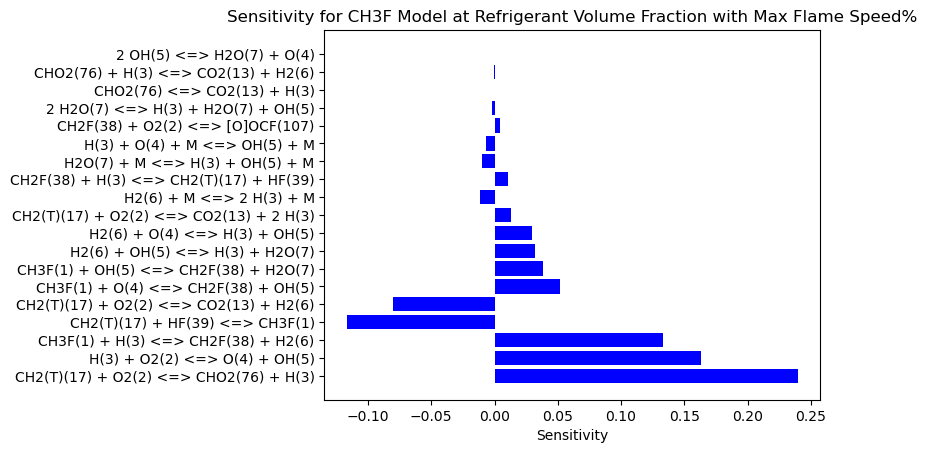

In [5]:
list_of_csvs = [file for file in os.listdir('.') if re.search('ies\.csv', file)]
list_of_csvs = ['CH3F_RMG_sensitivities.csv']

for file in list_of_csvs: 
    plot_sensitivity(file)

# Add in color and make it patterned

In [6]:
def plot_with_rxn_family(path, csv_file):
                         
    """ 
    Create the sensitivity plot, but list where the sensitive reactions are coming from.
    Path should be the path to the species folder.
    """
    #load the chemkin file                     
    species_list, reaction_list = load_chemkin_file(path)
    
    
    ################## plotting colors and patterns 
    family_colors = {'PDep': 'black', 
                       'FFCM1(-)': 'tab:red',
                       'ANL_Brown_pdep': 'tab:blue',
                       'H_Abstraction': 'forestgreen',
                    'halogens_pdep': 'gold',}

    family_patterns = {'PDep': '/', 
                       'FFCM1(-)': '\\',
                       'ANL_Brown_pdep': '|',
                       'H_Abstraction': '//',
                       'halogens_pdep': '||',}  
    
    #make a legend for these 
    patches = []
    fam_names = []
    for fam in family_patterns.keys():
        patch = mpatches.Patch(facecolor=family_colors[fam], hatch=family_patterns[fam])
        patches.append(patch)
        fam_names.append(fam)
    


                
    ############ plotting stuff like normal

    df = pd.read_csv(f'./{csv_file}')

    match = re.search('(\S+)_RMG_sensitivities.csv', file)
    blend = match.group(1)
    blend_name_to_save = blend
    
    #now get the subscripts right in the blend name 
    to_subscript = re.findall('[A-Z][0-9]', blend)
    for snippet in to_subscript: 
        blend=blend.replace(snippet, snippet[0]+r'\u208'+snippet[-1])
        formatted_blend_name = eval(f'f"{blend}"')


    fig, ax = plt.subplots()

    plt.xlabel('Normalized Sensitivity, '+ '$s_i$')
    plt.title(f"Normalized Sensitivity for {formatted_blend_name} Mechanism | Updated Database")# at Refrigerant Volume Fraction with Max Flame Speed%")
    
    #add in family legend
    ax.legend(patches, fam_names, title='Reaction Rate Source')

    
    

    ############# iterate over rows of csv file. 

    for index,row in df.head(n).iterrows(): #Only iterate over the first n rows


        sensitivity, ct_equation, products_dict, reactants_dict = row['sensitivity'], row['cantera equation'], eval(row['cantera products']), eval(row['cantera reactants'])
        species_involved_in_rxn = list(products_dict.keys())+ list(reactants_dict.keys())
        num_of_spec_involved = re.findall('\([0-9]+\)', str(species_involved_in_rxn))
        
        
        
        #can we find the reaction in the RMG mechanism?
        count = 0 #let's keep track of how many matches we find 
        for reaction in reaction_list:
            rxn_species = sorted([str(x) for x in reaction.reactants+reaction.products])
            rxn_species_indices = sorted([f'({x.index})' for x in reaction.reactants+reaction.products])
            if rxn_species == sorted(species_involved_in_rxn):
                print(f'matched: {reaction} with {ct_equation}')
                count +=1 
                try: 
                    family = reaction.family
                except AttributeError as e: 
                    if str(e)=="'PDepReaction' object has no attribute 'family'": 
                        family='PDep'
            elif all([x in num_of_spec_involved for x in rxn_species_indices]) and len(num_of_spec_involved)==len(rxn_species):
                print(f'matched: {reaction} with {ct_equation}')
                count +=1 
                try: 
                    family = reaction.family
                except AttributeError as e: 
                    if str(e)=="'PDepReaction' object has no attribute 'family'": 
                        family='PDep'
                
        assert count<=1, print(count)
        if count==1: 
            print(ct_equation, family)
        if count==0: #we didn't find a match
            print('NO MATCH  ' + ct_equation)
        
        #let's edit the equations so they look nice
        indices_to_take_out = re.findall('(\([0-9]+\))', ct_equation)
        for indices in indices_to_take_out: 
            ct_equation = ct_equation.replace(indices, '')
            
        #now get the subscripts right 
        to_subscript = re.findall('[A-Z][0-9]', ct_equation)
        for snippet in to_subscript: 
            ct_equation=ct_equation.replace(snippet, snippet[0]+r'\u208'+snippet[-1])
            formatted_equation = eval(f'f"{ct_equation}"')
            

        if to_subscript==[]:
            formatted_equation = ct_equation #if there was no need to edit subscripts 
           
        ax.barh(formatted_equation, sensitivity, color=family_colors[family], align='center', hatch=family_patterns[family])
    #plt.savefig(f'./Normalized_Sensitivities_{blend_name_to_save}_new_top_15.png', bbox_inches='tight')
        

matched: O2(2) + CH2(T)(17) <=> H(3) + [O]C=O(76) with CH2(T)(17) + O2(2) <=> CHO2(76) + H(3)
CH2(T)(17) + O2(2) <=> CHO2(76) + H(3) PDep
matched: O2(2) + H(3) <=> O(4) + OH(5) with H(3) + O2(2) <=> O(4) + OH(5)
H(3) + O2(2) <=> O(4) + OH(5) FFCM1(-)
matched: H(3) + CH3F(1) <=> H2(6) + CH2F(38) with CH3F(1) + H(3) <=> CH2F(38) + H2(6)
CH3F(1) + H(3) <=> CH2F(38) + H2(6) H_Abstraction
matched: HF(39) + CH2(T)(17) <=> CH3F(1) with CH2(T)(17) + HF(39) <=> CH3F(1)
CH2(T)(17) + HF(39) <=> CH3F(1) ANL_Brown_pdep
matched: O2(2) + CH2(T)(17) <=> H2(6) + CO2(13) with CH2(T)(17) + O2(2) <=> CO2(13) + H2(6)
CH2(T)(17) + O2(2) <=> CO2(13) + H2(6) FFCM1(-)
matched: O(4) + CH3F(1) <=> OH(5) + CH2F(38) with CH3F(1) + O(4) <=> CH2F(38) + OH(5)
CH3F(1) + O(4) <=> CH2F(38) + OH(5) H_Abstraction
matched: OH(5) + CH3F(1) <=> H2O(7) + CH2F(38) with CH3F(1) + OH(5) <=> CH2F(38) + H2O(7)
CH3F(1) + OH(5) <=> CH2F(38) + H2O(7) H_Abstraction
matched: OH(5) + H2(6) <=> H(3) + H2O(7) with H2(6) + OH(5) <=> H(3) +

AssertionError: None

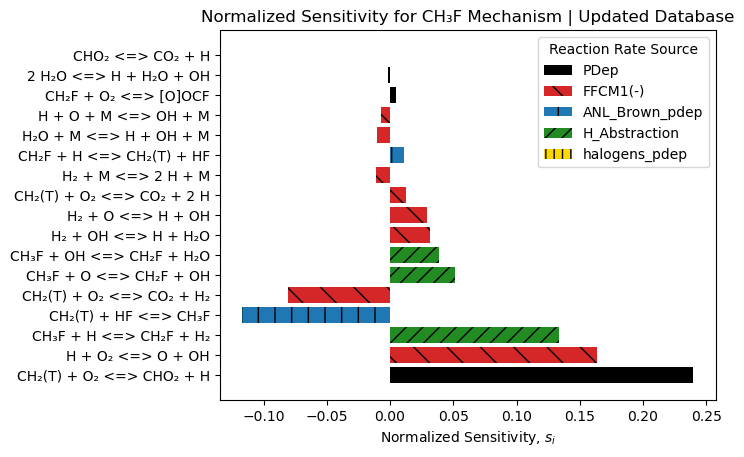

In [10]:
path = '/work/westgroup/nora/Code/projects/halogens/refrigerants/halogens_paper/models_diff/CH3F_before_and_after_rebase/rebased_RMG-Py-database/regenerating_model_at_different_commits/CH3F_main/CH3F_main_with_ANL_Brown_pdep/'
plot_with_rxn_family(path, 'CH3F_RMG_sensitivities.csv')

In [8]:
species_list, reaction_list = load_chemkin_file(path)

In [9]:
for reaction in reaction_list: 
    if "CH3F(1)" in [str(x) for x in reaction.reactants+reaction.products] and reaction.is_unimolecular(): 
        print(reaction)

HF(38) + CH2(T)(17) <=> CH3F(1)
CH3F(1) <=> HF(38) + CH2(S)(24)
H(3) + CH2F(45) <=> CH3F(1)
CH3F(1) <=> F(37) + CH3(18)


In [167]:
#another way to do it, only works if ALL numbers have to be replaced
equation='CH3F(1) <=> HF(38) + CH2(S)(24)'
sub=str.maketrans("012345", "\u2080"+"\u2081"+'\u2082'+'\u2083'+'\u2084'+'\u2085')
_str=equation
_str=_str.translate(sub)
print(_str)


CH₃F(₁) <=> HF(₃8) + CH₂(S)(₂₄)
